In [65]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ['KAGGLE_USERNAME'] = os.getenv("KAGGLE_USERNAME")
os.environ['KAGGLE_KEY'] = os.getenv("KAGGLE_KEY")

In [49]:
import pandas as pd

DATA_PATH = "./data/Books_rating.csv" 

df = pd.read_csv(DATA_PATH)
df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [50]:
df_analysis = pd.read_csv("./data/Books_rating.csv", nrows=100000)

df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Id                  100000 non-null  object 
 1   Title               99999 non-null   object 
 2   Price               12982 non-null   float64
 3   User_id             80784 non-null   object 
 4   profileName         80780 non-null   object 
 5   review/helpfulness  100000 non-null  object 
 6   review/score        100000 non-null  float64
 7   review/time         100000 non-null  int64  
 8   review/summary      99982 non-null   object 
 9   review/text         100000 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 7.6+ MB


In [51]:
df_analysis["review/text"].describe()

count                                                100000
unique                                                93565
top       This book is a great example of rational think...
freq                                                     14
Name: review/text, dtype: object

In [52]:
missing_count = df["review/text"].isna().sum()
empty_strings = (df["review/text"].fillna("").str.strip() == "").sum()
short_reviews = df["review/text"].fillna("").apply(lambda x: len(str(x).split()) <= 3).sum()

print(f"Number of NaN: {missing_count}")
print(f"Number of Empty string: {empty_strings}")
print(f"Number of very short strings (≤ 3 words): {short_reviews}")

Number of NaN: 8
Number of Empty string: 8
Number of very short strings (≤ 3 words): 864


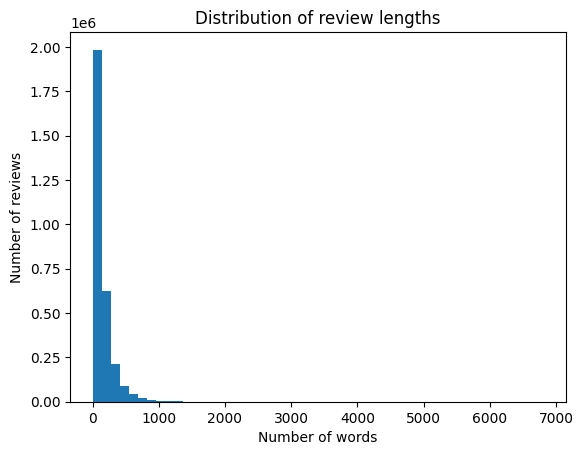

In [53]:
import matplotlib.pyplot as plt

review_lengths = df["review/text"].dropna().apply(lambda x: len(str(x).split()))

plt.hist(review_lengths, bins=50)
plt.xlabel("Number of words")
plt.ylabel("Number of reviews")
plt.title("Distribution of review lengths")

plt.savefig("distribution_of_review_lengths.png", dpi=300, bbox_inches='tight')  # PNG

plt.show()

In [54]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df = df[~df["review/text"].isna()]
df = df[df["review/text"].str.strip() != ""]

df["word_count"] = df["review/text"].apply(lambda x: len(x.split()))
df["is_short"] = df["word_count"] <= 3

df = df[df["word_count"] <= 500]

df["clean_text"] = df["review/text"].apply(clean_text)

df = df.reset_index(drop=True)

print(df[["review/text", "word_count", "is_short"]].head(10))

                                         review/text  word_count  is_short
0  This is only for Julie Strain fans. It's a col...          86     False
1  I don't care much for Dr. Seuss but after read...         252     False
2  If people become the books they read and if "t...         310     False
3  Philip Nel - Dr. Seuss: American IconThis is b...         273     False
4  "Dr. Seuss: American Icon" by Philip Nel is a ...         298     False
5  Theodor Seuss Giesel was best known as 'Dr. Se...          87     False
6  When I recieved this book as a gift for Christ...         210     False
7  Trams (or any public transport) are not usuall...          63     False
8  As far as I am aware, this is the first book-l...         243     False
9  I just finished the book, &quot;Wonderful Wors...         137     False


In [55]:
df_sample = df.sample(n=500, random_state=42).reset_index(drop=True)

In [56]:
def jaccard_similarity(str1, str2):
    set1 = set(str1.split())
    set2 = set(str2.split())
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    if not union:
        return 0.0
    return len(intersection) / len(union)

from tqdm import tqdm

similarities = []
n = len(df_sample)

for i in tqdm(range(n)):
    for j in range(i + 1, n):
        sim = jaccard_similarity(df_sample.loc[i, "clean_text"], df_sample.loc[j, "clean_text"])
        similarities.append((i, j, sim))

100%|██████████| 500/500 [00:05<00:00, 96.12it/s] 


In [57]:
similarities_sorted = sorted(similarities, key=lambda x: x[2], reverse=True)
for i, j, score in similarities_sorted[:10]:
    print(f"\n[{i}] {df_sample.loc[i, 'review/text']}\n[{j}] {df_sample.loc[j, 'review/text']}\nSimilarity: {score:.2f}")
    


[234] This book is excellent, I recommend it to all my customers.
[413] Excellent book ! Gives you the answers to all the Biblical dating questions you might have. I highly recommend it !
Similarity: 0.33

[130] I don't get to read alot with 3 kids, but I could NOT put this book down!!!
[229] Very good, hard to put this book down but did not want it to end.Would love to read more! Juanita
Similarity: 0.32

[230] The book is about 13 dwarves and one hobbit called Bilbo. The Hobbit is a good book to read. The book is mostly about adventer. If you like adventer this is a good book to read. I think that the book is very good to read in a camping place. I think that the book is very good book.
[436] This is written in the language of its day and is very enjoyable as a light read. If you've never read and like old fashioned romantic books this is a good one.
Similarity: 0.29

[67] I bought this as a present for my dad and he really loves it. It shipped very quickly and I had no problems at 

In [58]:
jaccard_results = []
for i in range(n):
    for j in range(i + 1, n):
        sim = jaccard_similarity(df_sample.loc[i, "clean_text"], df_sample.loc[j, "clean_text"])
        jaccard_results.append((i, j, sim))
        
jaccard_dict = {(i, j): sim for i, j, sim in jaccard_results}

In [59]:
import pandas as pd

top_pairs = similarities_sorted[:10]
results = []

for i, j, score in top_pairs:
    results.append({
        "i": i,
        "j": j,
        "i_text": df_sample.loc[i, "review/text"],
        "j_text": df_sample.loc[j, "review/text"],
        "similarity": score,
        "i_is_short": df_sample.loc[i, "is_short"],
        "j_is_short": df_sample.loc[j, "is_short"]
    })

results_df = pd.DataFrame(results)
results_df.to_csv("top_jaccard_pairs.csv", index=False)

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

texts = df_sample["clean_text"].tolist()

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(texts)

cos_sim_matrix = cosine_similarity(tfidf_matrix)

In [61]:
similarities = []

n = cos_sim_matrix.shape[0]
for i in range(n):
    for j in range(i + 1, n):
        sim = cos_sim_matrix[i, j]
        similarities.append((i, j, sim))

similarities_sorted = sorted(similarities, key=lambda x: x[2], reverse=True)
for i, j, score in similarities_sorted[:10]:
    print(f"\n[{i}] {df_sample.loc[i, 'review/text']}\n[{j}] {df_sample.loc[j, 'review/text']}\nTF-IDF Similarity: {score:.2f}")
    
tfidf_dict = {(i, j): sim for i, j, sim in similarities}


[153] This book was the best book I ever read. I really liked it and It was so good i could read it again and again
[214] It was a very magnificent book that I have read 3 times! It was so very exciting that it kept me on the edge of my seat the whole way through. It was a very creative book with a great storyline and it is so wonderful that it will cheer you up and draw you in to reading it again and again.
TF-IDF Similarity: 0.39

[48] I refer to the Folio Edition version of this novel.I read this book with my eight year-old son just after reading the third of the Harry Potter books (I had read 'The Hobbit' many years before). With the immanent release of the movie version of 'Lord of the Rings' following the release of 'The Philosopher's Stone' I wondered if my son was ready for 'The Lord of the Rings'. I had read 'The Lord of the Rings' several times many years ago and my memory of it was that it was a bit gruelling for a young boy to appreciate. 'The Hobbit' seemed to be a more g

In [62]:
import pandas as pd
top_n = 20
top_pairs = similarities_sorted[:top_n]

results = []

for i, j, score in top_pairs:
    results.append({
        "index_i": i,
        "index_j": j,
        "review_i": df_sample.loc[i, "review/text"],
        "review_j": df_sample.loc[j, "review/text"],
        "tfidf_similarity": score,
        "i_is_short": df_sample.loc[i, "is_short"],
        "j_is_short": df_sample.loc[j, "is_short"],
        "i_word_count": df_sample.loc[i, "word_count"],
        "j_word_count": df_sample.loc[j, "word_count"]
    })

results_df = pd.DataFrame(results)
results_df.to_csv("tfidf_similar_pairs.csv", index=False)

print("✅ TF-IDF results saved as tfidf_similar_pairs.csv.")

✅ TF-IDF results saved as tfidf_similar_pairs.csv.


In [63]:
comparison = []

for key in jaccard_dict.keys():
    if key in tfidf_dict:
        i, j = key
        comparison.append({
            "index_i": i,
            "index_j": j,
            "review_i": df_sample.loc[i, "review/text"],
            "review_j": df_sample.loc[j, "review/text"],
            "jaccard": jaccard_dict[key],
            "tfidf": tfidf_dict[key],
            "score_diff": tfidf_dict[key] - jaccard_dict[key]  # farkı analiz için
        })
        
comparison_df = pd.DataFrame(comparison)
# En yüksek benzerlik farkına göre sırala
comparison_df_sorted = comparison_df.sort_values(by="tfidf", ascending=False)

# CSV olarak kaydet
comparison_df_sorted.to_csv("jaccard_vs_tfidf.csv", index=False)

print("✅ Comparison results saved as jaccard_vs_tfidf.csv.")

✅ Comparison results saved as jaccard_vs_tfidf.csv.


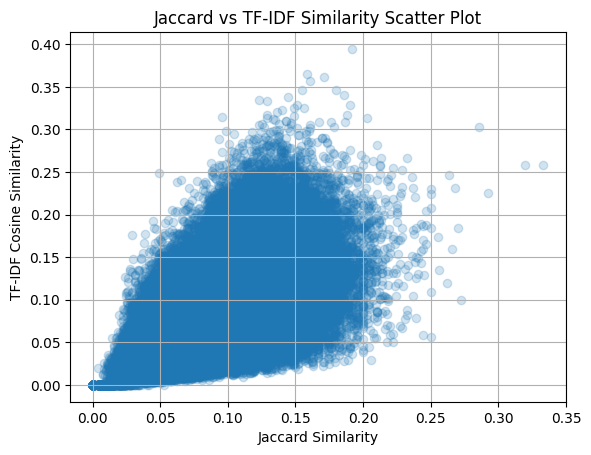

In [64]:
filtered = comparison_df[
    (comparison_df["tfidf"] > 0.3) & (comparison_df["jaccard"] < 0.15)
].sort_values(by="tfidf", ascending=False).head(20)

filtered.to_csv("tfidf_high_jaccard_low.csv", index=False)

comparison_df[
    (comparison_df["jaccard"] > 0.3) & (comparison_df["tfidf"] < 0.15)
].sort_values(by="jaccard", ascending=False).head(20)

import matplotlib.pyplot as plt

plt.scatter(comparison_df["jaccard"], comparison_df["tfidf"], alpha=0.2)
plt.xlabel("Jaccard Similarity")
plt.ylabel("TF-IDF Cosine Similarity")
plt.title("Jaccard vs TF-IDF Similarity Scatter Plot")
plt.grid(True)

plt.savefig("jaccard_vs_tfidf_plot.png", dpi=300, bbox_inches='tight')  # PNG

plt.show()